<a href="https://colab.research.google.com/github/bwsi-hadr/2019-student-final-exercise/blob/master/PR_Evacuation_information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# need to specify location of some certificates for rasterio
!export CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt
!sudo mkdir -p /etc/pki/tls/certs
!sudo cp /etc/ssl/certs/ca-certificates.crt /etc/pki/tls/certs/ca-bundle.crt
try:
  import rasterio
  import rasterio.plot
  import rasterio.merge 
  import rasterio.mask
except:
  !pip install rasterio
  import rasterio
  import rasterio.plot
  import rasterio.merge
  import rasterio.mask
  
try:
  import rasterstats as rs
except:
  !pip install rasterstats  
  import rasterstats as rs
  
try:
  import pyproj
except:
  !pip install pyproj
  import pyproj
  
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/BWSI-Remote-Sensing/'Final_exercise'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/BWSI-Remote-Sensing/Final_exercise


In [0]:
!ls game_grid_export

facilities	      flooding.prj	       game_grid_all_stats.dbf
facilities_stats.csv  flooding.shp	       game_grid_all_stats.prj
flooding.cpg	      flooding.shx	       game_grid_all_stats.shp
flooding.dbf	      game_grid_all_stats.cpg  game_grid_all_stats.shx


In [0]:
game_grid=gpd.read_file('game_grid_export/game_grid_all_stats.shp')
game_grid.head()

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,elevation,population,Health,Utility,Transporta,geometry
0,19TBH7019,BH,19T,270000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.797211,42.593785,196.344985,443,10,7,8,POLYGON ((-71.79092278136125 42.58943590354409...
1,19TBH7119,BH,19T,271000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.785036,42.594082,139.760744,381,10,7,8,POLYGON ((-71.77874932612048 42.58973201162303...
2,19TBH7219,BH,19T,272000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.772862,42.594377,144.429830,318,10,7,8,POLYGON ((-71.76657568741803 42.59002682737616...
3,19TBH7319,BH,19T,273000mE,4719000mN,19TBH71,0.042365,0.042365,0.00011,-71.760687,42.594671,154.567869,182,10,7,3,POLYGON ((-71.75440186615322 42.59032035170287...
4,19TBH7419,BH,19T,274000mE,4719000mN,19TBH71,0.042365,0.042365,0.00011,-71.748513,42.594964,176.765537,115,10,7,3,POLYGON ((-71.74222786322531 42.59061258370377...


In [0]:
flooding=gpd.read_file('game_grid_export/flooding.shp')
hospitals=gpd.read_file('game_grid_export/facilities/hospitals.shp')

In [0]:
meanel=game_grid['elevation'].mean()
meanpop=game_grid['population'].mean()
meanhel=game_grid['Health'].mean()
meanut=game_grid['Utility'].mean()
meantran=game_grid['Transporta'].mean()

In [0]:
game_grid['score']=(1-(game_grid['elevation']/meanel))+((game_grid['population']/meanpop))+(1-(game_grid['Health']/meanhel))+(1-(game_grid['Utility']/meanut)+(1-(game_grid['Transporta']/meantran)))

In [0]:
game_grid.head()

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,elevation,population,Health,Utility,Transporta,geometry,score
0,19TBH7019,BH,19T,270000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.797211,42.593785,196.344985,443,10,7,8,POLYGON ((-71.79092278136125 42.58943590354409...,-1.761306
1,19TBH7119,BH,19T,271000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.785036,42.594082,139.760744,381,10,7,8,POLYGON ((-71.77874932612048 42.58973201162303...,-0.911682
2,19TBH7219,BH,19T,272000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.772862,42.594377,144.429830,318,10,7,8,POLYGON ((-71.76657568741803 42.59002682737616...,-1.216120
3,19TBH7319,BH,19T,273000mE,4719000mN,19TBH71,0.042365,0.042365,0.00011,-71.760687,42.594671,154.567869,182,10,7,3,POLYGON ((-71.75440186615322 42.59032035170287...,-0.864546
4,19TBH7419,BH,19T,274000mE,4719000mN,19TBH71,0.042365,0.042365,0.00011,-71.748513,42.594964,176.765537,115,10,7,3,POLYGON ((-71.74222786322531 42.59061258370377...,-1.512013


In [0]:
flooding22=flooding.to_crs(epsg=3857).copy()
flood2=flooding.to_crs(epsg=3857).buffer(10000)
flooding22['geometry']=flood2



In [0]:
game_grid['population'].sum(axis=0)

3631498

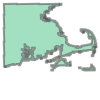

In [0]:
Mass=game_grid.geometry.unary_union
Mass

In [0]:
maxfloodpop = gpd.sjoin(game_grid, flooding22.to_crs(game_grid.crs), how="inner", op='intersects')
maxfloodpop['population'].sum(axis=0)

2973757

In [0]:
maxfloodpop['elevation'].max()

129.6523992365057

#Evacuation **`Plan`**
##can only evacuation 600,000 people PER TURN
###(16 turns) starts at level 5 and can downgrade or remain the same per turn

In [0]:
flooding22=flooding.to_crs(epsg=3857).copy()
flood2=flooding.to_crs(epsg=3857).buffer(8000)
flooding22['geometry']=flood2
maxfloodpop2 = gpd.sjoin(game_grid, flooding22.to_crs(game_grid.crs), how="inner", op='intersects')

In [0]:
flooding22=flooding.to_crs(epsg=3857).copy()
flood2=flooding.to_crs(epsg=3857).buffer(6000)
flooding22['geometry']=flood2
maxfloodpop3 = gpd.sjoin(game_grid, flooding22.to_crs(game_grid.crs), how="inner", op='intersects')

In [0]:
flooding22=flooding.to_crs(epsg=3857).copy()
flood2=flooding.to_crs(epsg=3857).buffer(4000)
flooding22['geometry']=flood2
maxfloodpop4 = gpd.sjoin(game_grid, flooding22.to_crs(game_grid.crs), how="inner", op='intersects')

In [0]:
flooding22=flooding.to_crs(epsg=3857).copy()
flood2=flooding.to_crs(epsg=3857).buffer(2000)
flooding22['geometry']=flood2
maxfloodpop5 = gpd.sjoin(game_grid, flooding22.to_crs(game_grid.crs), how="inner", op='intersects')

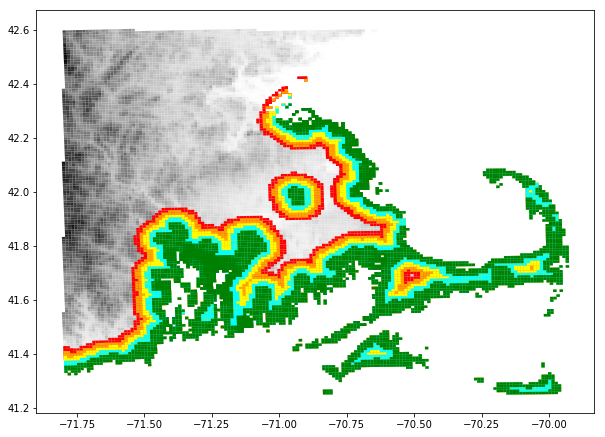

In [0]:
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='elevation',cmap='binary')
maxfloodpop.to_crs(game_grid.crs).plot(color='red',alpha=1, ax=ax,zorder=10)
maxfloodpop2.to_crs(game_grid.crs).plot(color='orange',alpha=1, ax=ax,zorder=10)
maxfloodpop3.to_crs(game_grid.crs).plot(color='yellow',alpha=1, ax=ax,zorder=10)
maxfloodpop4.to_crs(game_grid.crs).plot(color='aqua',alpha=1, ax=ax,zorder=10)
maxfloodpop5.to_crs(game_grid.crs).plot(color='green',alpha=1, ax=ax,zorder=10)






#Evacution Plan Part 2

In [0]:
#Level 1 storm
maxfloodpop5p=3442
mpfs=maxfloodpop5.sort_values('elevation')
maxfloodpop5elev=mpfs.iloc[3442]['elevation']

query1 = ((maxfloodpop5['elevation']<maxfloodpop5elev)) 
level1=maxfloodpop5.loc[query1]


In [0]:
len(maxfloodpop5)

3624

In [0]:
#level 2 storm
maxfloodpop4p=5000
mpss=maxfloodpop4.sort_values('elevation')
maxfloodpop4elev=mpss.iloc[5000]['elevation']

query2 = ((maxfloodpop4['elevation']<maxfloodpop4elev)) 
level2=maxfloodpop4.loc[query2]

In [0]:
#Level 3 storm
maxfloodpop3p=6536
mphs=maxfloodpop3.sort_values('elevation')
maxfloodpop3elev=mphs.iloc[6536]['elevation']

query3 = ((maxfloodpop3['elevation']<maxfloodpop4elev)) 
level3=maxfloodpop3.loc[query3]

In [0]:
#Level 4 storm
maxfloodpop2p=8117.75
mphs=maxfloodpop2.sort_values('elevation')
maxfloodpop2elev=mphs.iloc[8117]['elevation']

query4 = ((maxfloodpop2['elevation']<maxfloodpop4elev)) 
level4=maxfloodpop2.loc[query4]

In [0]:
#Level 5 storm
maxfloodpopp=9781
mphs=maxfloodpop.sort_values('elevation')
maxfloodpopelev=mphs.iloc[9781]['elevation']

query5 = ((maxfloodpop['elevation']<maxfloodpop4elev)) 
level5=maxfloodpop.loc[query5]

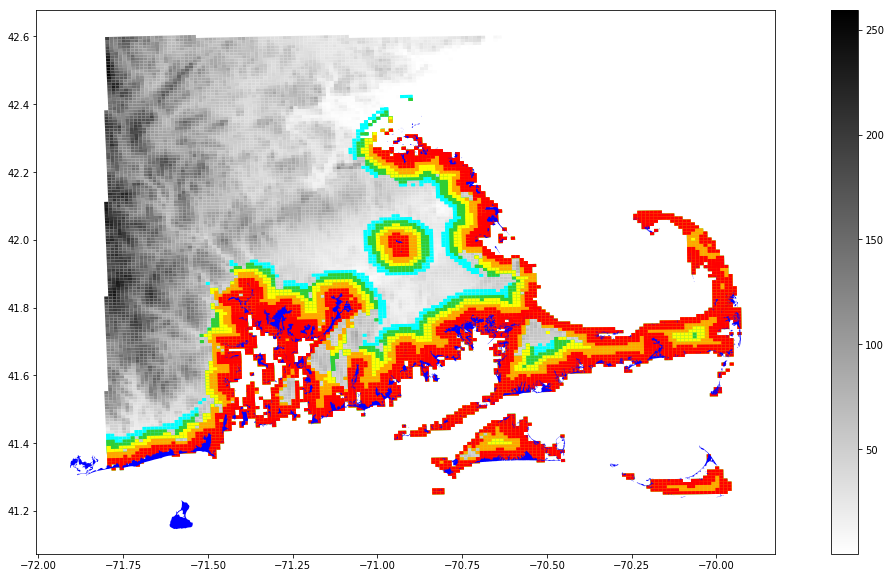

In [0]:
fig=plt.figure(figsize=[20,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='elevation',cmap='binary',legend='True')

level5.to_crs(game_grid.crs).plot(color='aqua',alpha=1, ax=ax,zorder=10)
level4.to_crs(game_grid.crs).plot(color='limegreen',alpha=1, ax=ax,zorder=10)
level3.to_crs(game_grid.crs).plot(color='yellow',alpha=1, ax=ax,zorder=10)
level2.to_crs(game_grid.crs).plot(color='orange',alpha=1, ax=ax,zorder=10)
level1.to_crs(game_grid.crs).plot(color='red',alpha=1, ax=ax,zorder=10)
flooding.to_crs(game_grid.crs).plot(color='blue',alpha=1,ax=ax,zorder=10)




#Adjusted Evacuation Plan

In [0]:
def evac_per_day(level):
  for i in range(0,len(level)):
    mpfs=level.sort_values('elevation')
    elev=mpfs.iloc[i]['elevation']

    querys = ((level['elevation']<elev)) 
    levelss=level.loc[querys]

    if levelss['population'].sum()>600000:
     evacval=i-1
     return evacval
     break
  



In [0]:
yip=evac_per_day(level5)



In [0]:
mpfs=level5.sort_values('elevation')

day1=mpfs[:2651]
day2=mpfs[2651:4716]
day3=mpfs[4716:6427]
day4=mpfs[6427:8454]


In [0]:
selection = level2['geometry'].difference(day1)
sekec = gpd.GeoDataFrame()
sekec['geometry']=selection




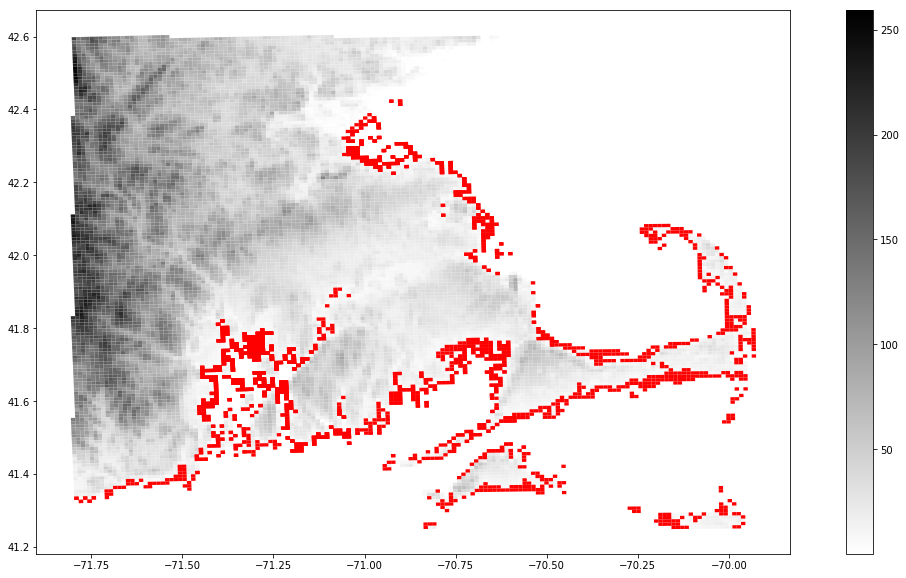

In [385]:
fig=plt.figure(figsize=[20,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='elevation',cmap='binary',legend='True')

day1.to_crs(game_grid.crs).plot(color='red',alpha=1, ax=ax,zorder=10)
#day2.to_crs(game_grid.crs).plot(color='blue',alpha=1, ax=ax,zorder=10)
#day3.to_crs(game_grid.crs).plot(color='turquoise',alpha=1, ax=ax,zorder=10)
#day4.to_crs(game_grid.crs).plot(color='green',alpha=1, ax=ax,zorder=10)

plt.savefig('evac_lan')



In [386]:
day1

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,elevation,population,Health,Utility,Transporta,geometry,score,index_right,STATE_NAME
12382,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,0.200436,0,10,5,3,POLYGON ((-70.00702313710809 41.53824772675114...,1.689431,4,Massachusetts
11178,19TCF2994,CF,19T,329000mE,4594000mN,19TCF29,0.041958,0.041958,0.000108,-71.042270,41.483989,0.200880,3,10,7,3,POLYGON ((-71.03614388353338 41.47959420730677...,1.419392,3,Massachusetts
11178,19TCF2994,CF,19T,329000mE,4594000mN,19TCF29,0.041958,0.041958,0.000108,-71.042270,41.483989,0.200880,3,10,7,3,POLYGON ((-71.03614388353338 41.47959420730677...,1.419392,9,Rhode Island
11178,19TCF2994,CF,19T,329000mE,4594000mN,19TCF29,0.041958,0.041958,0.000108,-71.042270,41.483989,0.200880,3,10,7,3,POLYGON ((-71.03614388353338 41.47959420730677...,1.419392,15,Rhode Island
11178,19TCF2994,CF,19T,329000mE,4594000mN,19TCF29,0.041958,0.041958,0.000108,-71.042270,41.483989,0.200880,3,10,7,3,POLYGON ((-71.03614388353338 41.47959420730677...,1.419392,10,Massachusetts
11631,19TBF8884,BF,19T,288000mE,4584000mN,19TBF88,0.041914,0.041914,0.000108,-71.529460,41.384237,0.203580,86,10,7,3,POLYGON ((-71.52331127639428 41.37986931821445...,1.704876,16,Rhode Island
10536,19TCG1403,CG,19T,314000mE,4603000mN,19TCG10,0.041984,0.041984,0.000108,-71.224591,41.561665,0.205319,5,10,7,3,"POLYGON ((-71.2184456155727 41.55728058013466,...",1.426189,9,Rhode Island
10536,19TCG1403,CG,19T,314000mE,4603000mN,19TCG10,0.041984,0.041984,0.000108,-71.224591,41.561665,0.205319,5,10,7,3,"POLYGON ((-71.2184456155727 41.55728058013466,...",1.426189,15,Rhode Island
11363,19TCF4490,CF,19T,344000mE,4590000mN,19TCF49,0.041948,0.041948,0.000108,-70.861663,41.451027,0.210083,0,10,5,3,POLYGON ((-70.85555183195146 41.44662270577322...,1.689249,2,Massachusetts
10062,19TCG8909,CG,19T,389000mE,4609000mN,19TCG80,0.042019,0.042019,0.000108,-70.326577,41.629579,0.214756,8,10,7,3,POLYGON ((-70.32048423206163 41.62514556211795...,1.436332,4,Massachusetts


#Where we export

In [0]:
import geopandas as gpd

In [380]:
yip=day1.unary_union
type(yip)

my_gdf = gpd.GeoDataFrame()
my_gdf['geometry']=yip

my_gdf.head()



,geometry
0,"POLYGON ((-70.4988271349643 41.55090266732424,..."
1,POLYGON ((-71.01303979025408 41.50702135964798...
2,"POLYGON ((-71.25690175131479 41.6285835920591,..."
3,POLYGON ((-70.20806253625705 42.03168416948881...
4,POLYGON ((-70.02285049285592 41.78129792555882...


In [376]:
pwd

'/root'

In [0]:
day1.to_file('evacuation.shp')

In [375]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Evacuation Table (ignore until fixed)

# Absolute Master Flooding Map

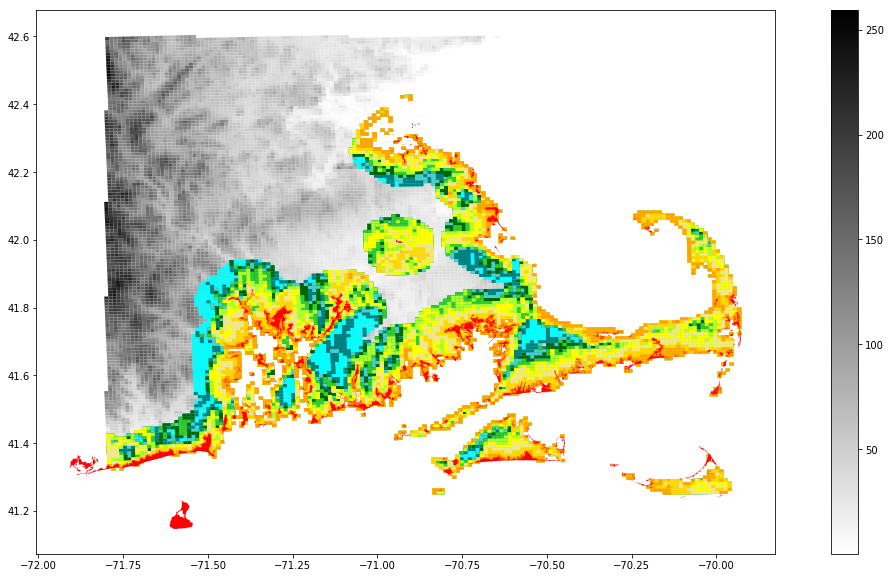

In [0]:
fig=plt.figure(figsize=[20,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='elevation',cmap='binary',legend='True')

#max bad
maxfloodpop.to_crs(game_grid.crs).plot(color='aqua',alpha=1, ax=ax,zorder=10)

#50 meters
query = ((maxfloodpop['elevation']<50)) 
fifless=maxfloodpop.loc[query]
fifless.to_crs(game_grid.crs).plot(color='teal',alpha=1, ax=ax,zorder=10)
fifpopt=fifless['population'].sum(axis=0)

#40 meters
query = ((maxfloodpop['elevation']<40)) 
frtless=maxfloodpop.loc[query]
frtless.to_crs(game_grid.crs).plot(color='mediumturquoise',alpha=1, ax=ax,zorder=10)
frtpop=frtless['population'].sum(axis=0)


#35 meters
query = ((maxfloodpop['elevation']<35)) 
thfless=maxfloodpop.loc[query]
thfless.to_crs(game_grid.crs).plot(color='darkgreen',alpha=1, ax=ax,zorder=10)
thfpop=thfless['population'].sum(axis=0)


#30 meters
query = ((maxfloodpop['elevation']<30)) 
thrless=maxfloodpop.loc[query]
thrless.to_crs(game_grid.crs).plot(color='limegreen',alpha=1, ax=ax,zorder=10)
thrpop=thrless['population'].sum(axis=0)


#25 meters
query = ((maxfloodpop['elevation']<25)) 
twfless=maxfloodpop.loc[query]
twfless.to_crs(game_grid.crs).plot(color='greenyellow',alpha=1, ax=ax,zorder=10)
twfpop=twfless['population'].sum(axis=0)


#20 meters
query = ((maxfloodpop['elevation']<20)) 
tweless=maxfloodpop.loc[query]
tweless.to_crs(game_grid.crs).plot(color='yellow',alpha=1, ax=ax,zorder=10)
twepop=tweless['population'].sum(axis=0)


#15 meters
query = ((maxfloodpop['elevation']<15)) 
fifless=maxfloodpop.loc[query]
fifless.to_crs(game_grid.crs).plot(color='khaki',alpha=1, ax=ax,zorder=10)
fifpop=fifless['population'].sum(axis=0)


#10 meters
query = ((maxfloodpop['elevation']<10)) 
tenless=maxfloodpop.loc[query]
tenless.to_crs(game_grid.crs).plot(color='gold',alpha=1, ax=ax,zorder=10)
tenpop=tenless['population'].sum(axis=0)


#5 meters
query = ((maxfloodpop['elevation']<5)) 
fiveless=maxfloodpop.loc[query]
fiveless.to_crs(game_grid.crs).plot(color='orange',alpha=1, ax=ax,zorder=10)
fivepop=fiveless['population'].sum(axis=0)



#regular
flooding.to_crs(game_grid.crs).plot(color='red',alpha=1, ax=ax,zorder=10)




#Elevation Time Table

In [0]:
col_names =  ['Elevation', 'Population']
my_df  = pd.DataFrame(columns = col_names)


elevation=['known',5,10,15,20,25,30,35,40,50,'max']
population=[323035,fivepop,tenpop,fifpop,twepop,twfpop,thrpop,thfpop,frtpop,fifpopt,2973757]

my_dic = {'Elevation':'known', 'Population':323035}
my_df.loc[len(my_df)] = my_dic 

for i in range(1,len(elevation)):
  my_df.loc[i]=[elevation[i]]+[population[i]]

my_df['Time in Days']=(my_df['Population']/500000)**2
my_df

,Elevation,Population,Time in Days
0,known,323035,0.417406
1,5,428100,0.733078
2,10,931388,3.46993
3,15,1282820,6.58251
4,20,1638551,10.7394
5,25,1973455,15.5781
6,30,2191491,19.2105
7,35,2354746,22.1793
8,40,2469102,24.3859
9,50,2672081,28.5601


In [0]:
game_grid.sort_values('elevation')

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,elevation,population,Health,Utility,Transporta,geometry,score
12382,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,0.200436,0,10,5,3,POLYGON ((-70.00702313710809 41.53824772675114...,1.689431
11178,19TCF2994,CF,19T,329000mE,4594000mN,19TCF29,0.041958,0.041958,0.000108,-71.042270,41.483989,0.200880,3,10,7,3,POLYGON ((-71.03614388353338 41.47959420730677...,1.419392
11631,19TBF8884,BF,19T,288000mE,4584000mN,19TBF88,0.041914,0.041914,0.000108,-71.529460,41.384237,0.203580,86,10,7,3,POLYGON ((-71.52331127639428 41.37986931821445...,1.704876
10536,19TCG1403,CG,19T,314000mE,4603000mN,19TCG10,0.041984,0.041984,0.000108,-71.224591,41.561665,0.205319,5,10,7,3,"POLYGON ((-71.2184456155727 41.55728058013466,...",1.426189
11363,19TCF4490,CF,19T,344000mE,4590000mN,19TCF49,0.041948,0.041948,0.000108,-70.861663,41.451027,0.210083,0,10,5,3,POLYGON ((-70.85555183195146 41.44662270577322...,1.689249
10062,19TCG8909,CG,19T,389000mE,4609000mN,19TCG80,0.042019,0.042019,0.000108,-70.326577,41.629579,0.214756,8,10,7,3,POLYGON ((-70.32048423206163 41.62514556211795...,1.436332
12368,19TDG2012,DG,19T,420000mE,4612000mN,19TDG21,0.042033,0.042033,0.000108,-69.954874,41.660289,0.214893,6,10,7,3,POLYGON ((-69.94880272936246 41.65583584424877...,1.429449
10035,19TCG4109,CG,19T,341000mE,4609000mN,19TCG40,0.042010,0.042010,0.000108,-70.902568,41.621487,0.216659,6,10,7,3,"POLYGON ((-70.8964379547478 41.61708493502169,...",1.429416
9318,19TBG9915,BG,19T,299000mE,4615000mN,19TBG91,0.042019,0.042019,0.000108,-71.408347,41.666037,0.217448,92,10,7,3,POLYGON ((-71.40217865372188 41.66166317321682...,1.725256
11002,19TCF2997,CF,19T,329000mE,4597000mN,19TCF29,0.041968,0.041968,0.000108,-71.043119,41.510994,0.218401,10,10,7,3,"POLYGON ((-71.0369900835255 41.50659949756874,...",1.443144


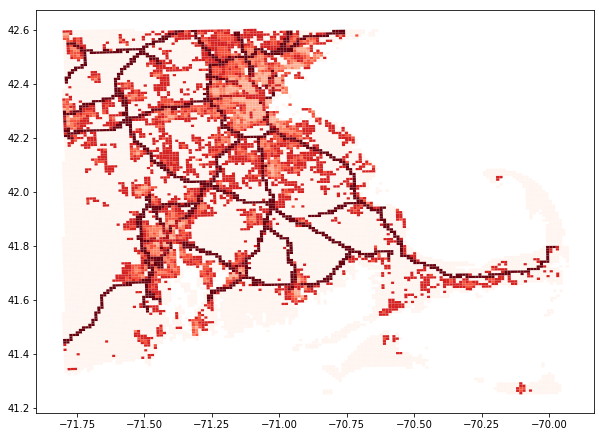

In [0]:
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='Transporta',cmap='Reds')


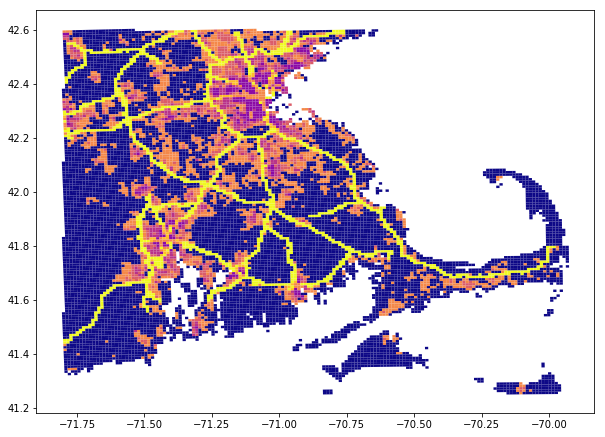

In [0]:
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='Transporta',cmap='plasma')



In [0]:
	
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='elevation',cmap='Reds')




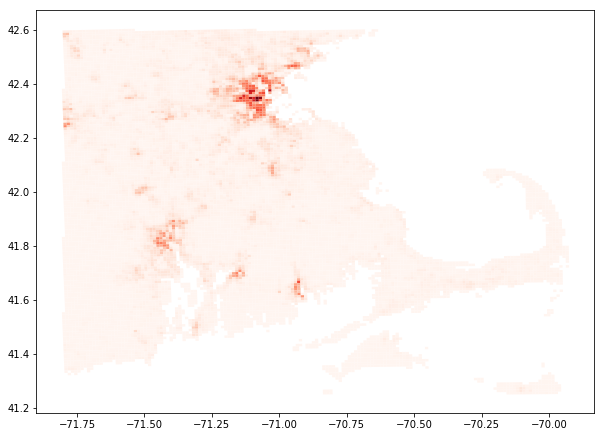

In [0]:
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='population',cmap='Reds')

In [0]:
flooding=gpd.read_file('game_grid_export/flooding.shp')
hospitals=gpd.read_file('game_grid_export/facilities/hospitals.shp')
#popflood=flooding.copy

#satA = pd.merge(state_abbrevs,sat, how='inner',
#                 left_on='state', right_on='state')
#floodpop=gpd.overlay(flooding.to_crs(game_grid.crs), game_grid, how='intersection')
floodpop = gpd.sjoin(game_grid, flooding.to_crs(game_grid.crs), how="inner", op='intersects')
floodpop.head()


,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,elevation,population,Health,Utility,Transporta,geometry,score,index_right,STATE_NAME
2537,19TCG4285,CG,19T,342000mE,4685000mN,19TCG48,0.042266,0.042266,0.000109,-70.910912,42.305819,5.739701,461,10,7,8,POLYGON ((-70.90471358096698 42.30141894053168...,1.881071,0,Massachusetts
2538,19TCG4385,CG,19T,343000mE,4685000mN,19TCG48,0.042267,0.042267,0.000109,-70.898786,42.306020,1.228912,318,10,7,8,POLYGON ((-70.89258808836956 42.30161976633912...,1.473859,0,Massachusetts
2539,19TCG4485,CG,19T,344000mE,4685000mN,19TCG48,0.042267,0.042267,0.000109,-70.886660,42.306220,4.615689,616,10,8,7,POLYGON ((-70.88046247166574 42.30181931151202...,2.497212,0,Massachusetts
2606,19TCG4084,CG,19T,340000mE,4684000mN,19TCG48,0.042263,0.042263,0.000109,-70.934889,42.296411,3.079705,0,10,5,3,POLYGON ((-70.92868941318585 42.29201235658496...,1.635345,0,Massachusetts
2607,19TCG4484,CG,19T,344000mE,4684000mN,19TCG48,0.042263,0.042263,0.000109,-70.886391,42.297219,0.362871,549,10,8,7,POLYGON ((-70.88019458970854 42.29281797107251...,2.346608,0,Massachusetts


In [0]:
floodpop['population'].sum(axis=0)

323035

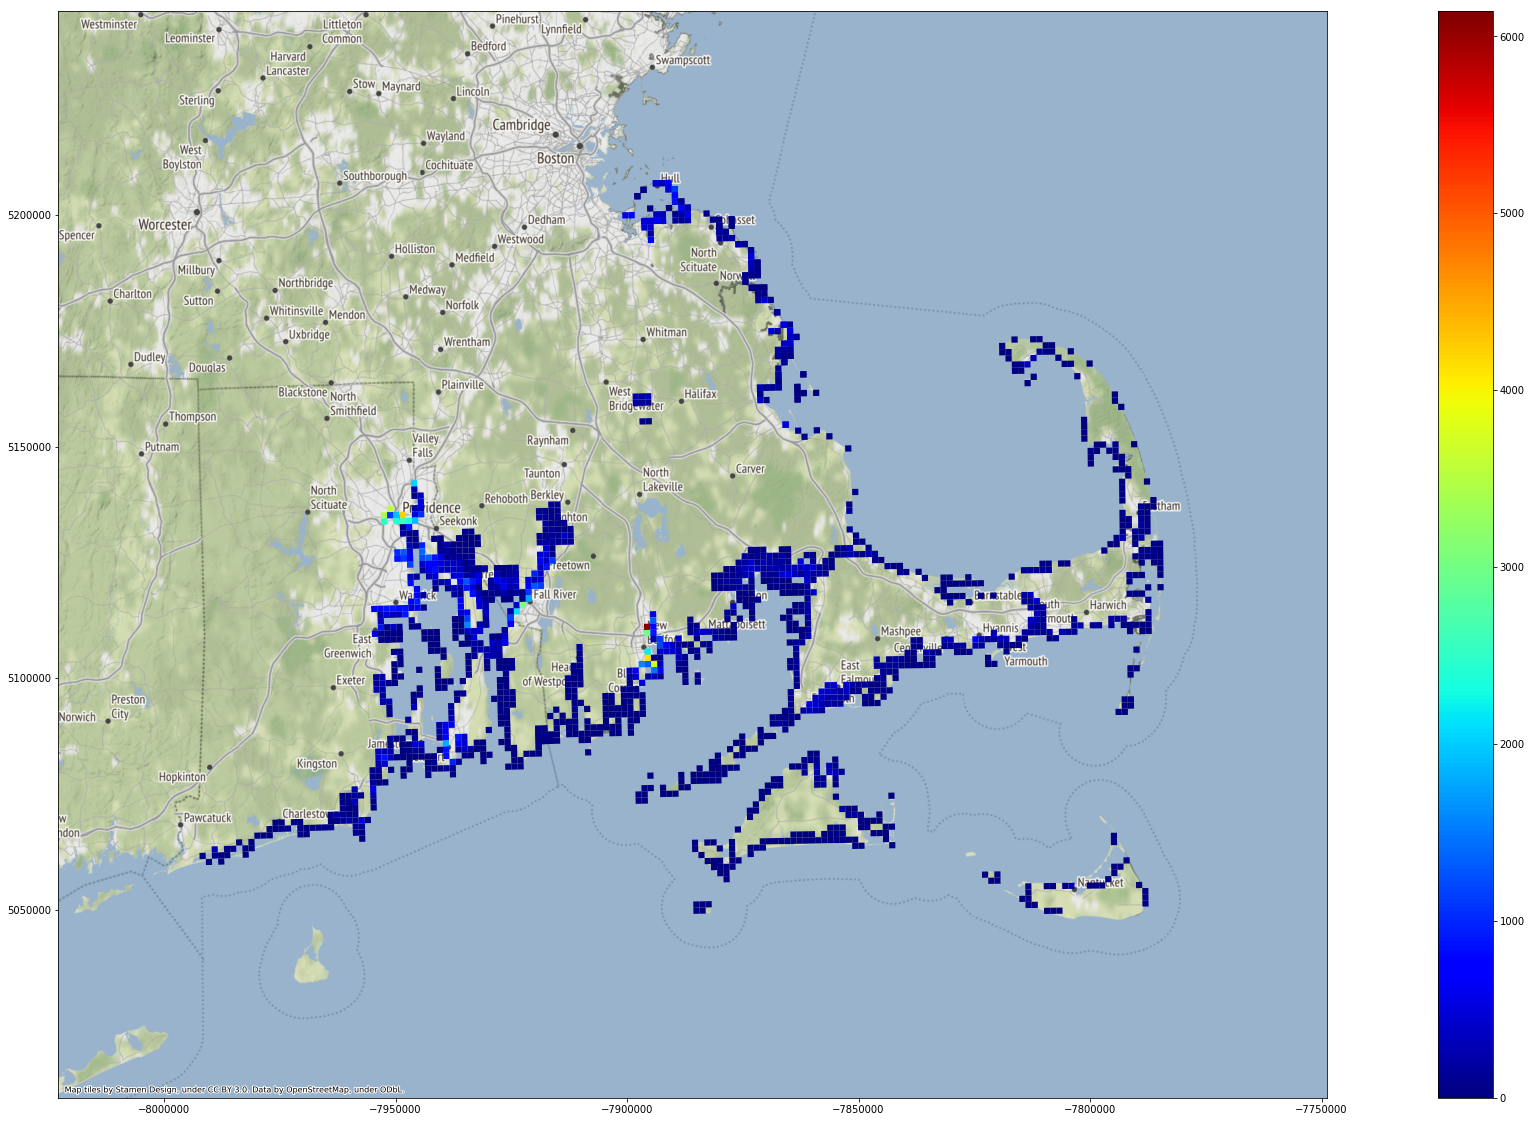

In [0]:


ax = floodpop.to_crs(epsg=3857).plot(column='population',figsize=(40,20), alpha=1, cmap='jet',legend='True')
ctx.add_basemap(ax, url=getattr(ctx.sources,'ST_TERRAIN'))
#ax.set(xlim=[-8000000,-7900000],ylim=[5100000,5150000])


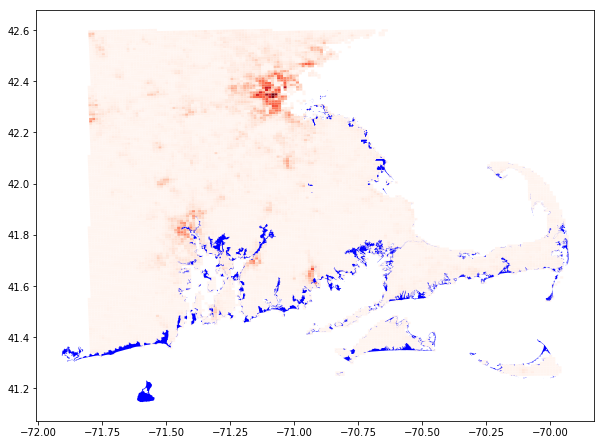

In [0]:
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
game_grid.plot(ax=ax,column='population',cmap='Reds')
flooding.to_crs(game_grid.crs).plot(color='blue', ax=ax,zorder=10)



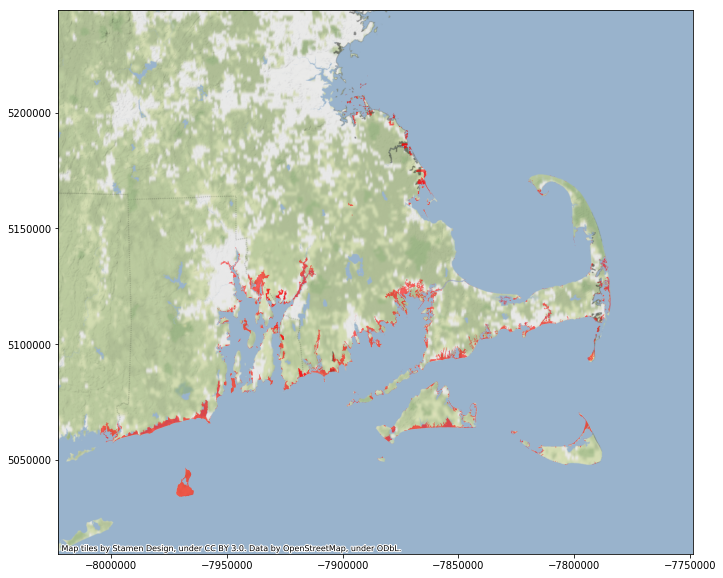

In [0]:
ax = flooding.to_crs(epsg=3857).plot(figsize=(20,10), alpha=0.6, color='red')
#flooding.to_crs(game_grid.crs).plot(color='blue')
ctx.add_basemap(ax, url=getattr(ctx.sources,'ST_TERRAIN_BACKGROUND'))